In [4]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import itertools

from utilities2015 import *

from joblib import Parallel, delayed

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
section_id = 100

dm = DataManager(stack='MD593', section=section_id, segm_params_id='gridsize200')
dm._load_image(versions=['gray'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


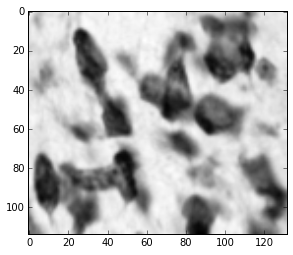

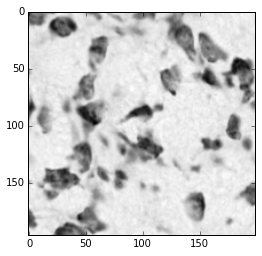

In [25]:
patch = dm.image[5488:5488+114, 2109:2109+132]

plt.imshow(patch, cmap=plt.cm.Greys_r)
plt.show()

patch2 = dm.image[5804:5804+196, 2001:2001+199]

plt.imshow(patch2, cmap=plt.cm.Greys_r)
plt.show()

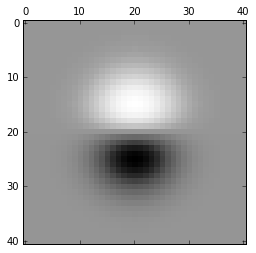

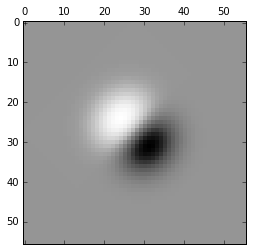

In [12]:
# Gaussian derivatives

from scipy.ndimage.filters import gaussian_filter
import numpy as np

center = np.array([25, 25])
pulse = np.zeros((2*center+1))
pulse[center[0], center[1]] = 1.
weights = gaussian_filter(pulse, sigma=5., order=[1, 0])

def crop(x):

    rs, cs = np.where(x != 0)
    rmin = rs.min()
    rmax = rs.max()
    cmin = cs.min()
    cmax = cs.max()
    
    return x[rmin:rmax+1, cmin:cmax+1].copy()

weights = crop(weights)

plt.matshow(weights, cmap=plt.cm.Greys_r)

from scipy.ndimage.interpolation import rotate

weights_rotated = rotate(weights, 45)
weights_rotated = crop(weights_rotated)

plt.matshow(weights_rotated, cmap=plt.cm.Greys_r)
plt.show()

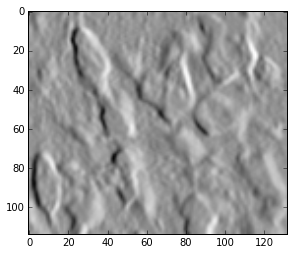

In [15]:
Gxx = np.zeros_like(patch)
gaussian_filter(patch, sigma=.5, order=[0,1], output=Gxx)
plt.imshow(Gxx, cmap=plt.cm.Greys_r)
plt.show()

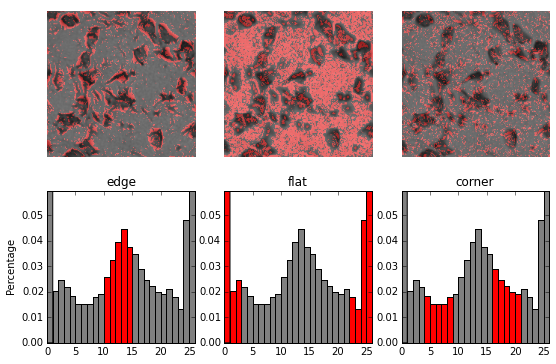

In [23]:
# Local Binary Pattern

from skimage.feature import local_binary_pattern

radius = 3
n_points = 8 * radius
METHOD = 'uniform'

lbp = local_binary_pattern(patch, n_points, radius, METHOD)
# lbp = local_binary_pattern(patch2, n_points, radius, METHOD)

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        
def hist(ax, lbp):
    n_bins = lbp.max() + 1
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
#     ax.imshow(overlay_labels(patch, lbp, labels))
    ax.imshow(overlay_labels(patch2, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')